Mounted at /content/drive
Archive:  /content/drive/MyDrive/BetelLeafDataset/Dataset.zip
   creating: /content/Dataset/
   creating: /content/Dataset/Poor/
  inflating: /content/Dataset/Poor/Poor0001.jpg  
  inflating: /content/Dataset/Poor/Poor0002.jpg  
  inflating: /content/Dataset/Poor/Poor0003.jpg  
  inflating: /content/Dataset/Poor/Poor0004.jpg  
  inflating: /content/Dataset/Poor/Poor0005.jpg  
  inflating: /content/Dataset/Poor/Poor0006.jpg  
  inflating: /content/Dataset/Poor/Poor0007.jpg  
  inflating: /content/Dataset/Poor/Poor0008.jpg  
  inflating: /content/Dataset/Poor/Poor0009.jpg  
  inflating: /content/Dataset/Poor/Poor0010.jpg  
  inflating: /content/Dataset/Poor/Poor0011.jpg  
  inflating: /content/Dataset/Poor/Poor0012.jpg  
  inflating: /content/Dataset/Poor/Poor0013.jpg  
  inflating: /content/Dataset/Poor/Poor0014.jpg  
  inflating: /content/Dataset/Poor/Poor0015.jpg  
  inflating: /content/Dataset/Poor/Poor0016.jpg  
  inflating: /content/Dataset/Poor/Poor0017.j

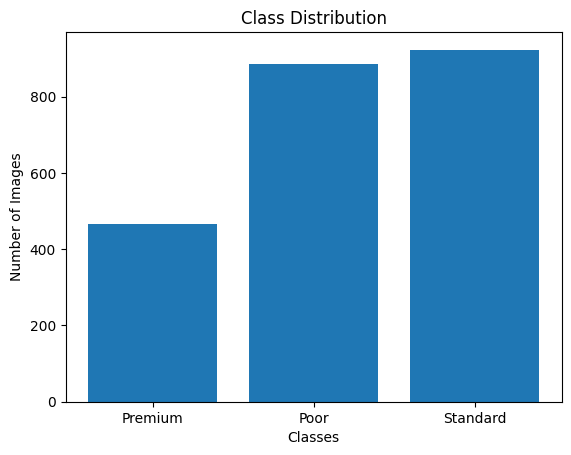

{'Premium': 465, 'Poor': 886, 'Standard': 923}

In [1]:
# ============================================================
# 1. Mount Drive and Load Dataset
# ============================================================
from google.colab import drive
drive.mount('/content/drive')

!unzip "/content/drive/MyDrive/BetelLeafDataset/Dataset.zip" -d "/content/"
DATASET_PATH = "/content/Dataset"  # change if needed

import os
import matplotlib.pyplot as plt

classes = os.listdir(DATASET_PATH)
class_counts = {}

for cls in classes:
    class_path = os.path.join(DATASET_PATH, cls)
    if os.path.isdir(class_path):
        class_counts[cls] = len(os.listdir(class_path))

plt.bar(class_counts.keys(), class_counts.values())
plt.title("Class Distribution")
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.show()

class_counts


In [2]:
TEST_PATH = "/content/Dataset_test"       # Separate folder for test set
TARGET_SIZE = (224, 224)
BATCH_SIZE = 32

from sklearn.model_selection import train_test_split
import shutil

os.makedirs(TEST_PATH, exist_ok=True)

classes = os.listdir(DATASET_PATH)

for cls in classes:
    cls_path = os.path.join(DATASET_PATH, cls)
    os.makedirs(os.path.join(TEST_PATH, cls), exist_ok=True)

    images = os.listdir(cls_path)
    test_images = train_test_split(images, test_size=0.15, random_state=42)[1]  # 15% test

    for img in test_images:
        shutil.move(os.path.join(cls_path, img), os.path.join(TEST_PATH, cls, img))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Classes: ['Poor', 'Premium', 'Standard']
Found 342 images belonging to 3 classes.

Loading Custom CNN from: /content/drive/MyDrive/best_betel_leaf_model.h5


  → Using input size: (224, 224)
Found 342 images belonging to 3 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  → Test Accuracy: 95.029% | FPS: 10.1 | Size: 99.49 MB

Loading EfficientNetB3 from: /content/drive/MyDrive/BetelLeaf_Perfect_EfficientNetB3.keras
  → Using input size: (300, 300)
Found 342 images belonging to 3 classes.
  → Test Accuracy: 96.199% | FPS: 4.5 | Size: 40.82 MB

Loading EfficientNetV2-M from: /content/drive/MyDrive/BetelLeaf_ULTIMATE_V2M.keras
  → Using input size: (480, 480)
Found 342 images belonging to 3 classes.
  → Test Accuracy: 96.199% | FPS: 3.3 | Size: 204.16 MB

           FINAL MODEL COMPARISON
           Model Test Accuracy (%) FPS (inf/s) Model Size (MB) Inference Time (s)
      Custom CNN            95.029        10.1            99.5              33.94
  EfficientNetB3            96.199         4.5            40.8              76.42
EfficientNetV2-M            96.199         3.3           204.2             102.72


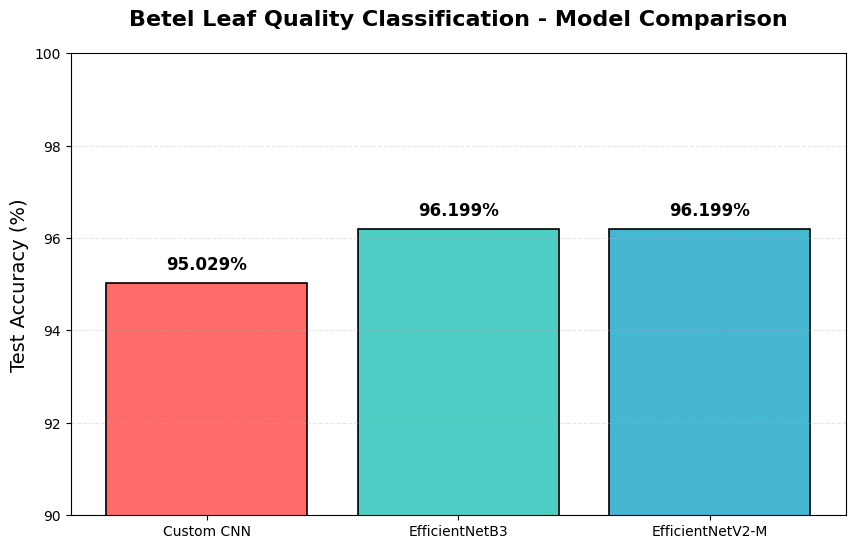

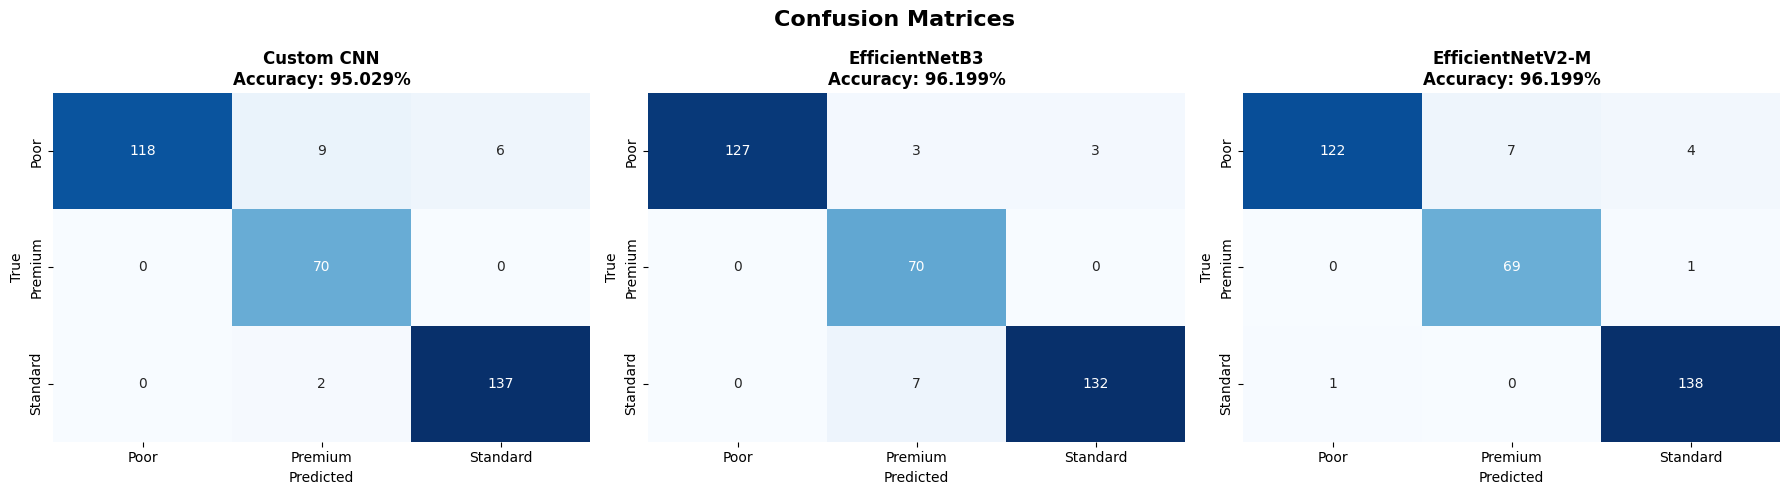


PER-CLASS PERFORMANCE

→ Custom CNN
              precision    recall  f1-score   support

        Poor     1.0000    0.8872    0.9402       133
     Premium     0.8642    1.0000    0.9272        70
    Standard     0.9580    0.9856    0.9716       139

    accuracy                         0.9503       342
   macro avg     0.9407    0.9576    0.9463       342
weighted avg     0.9552    0.9503    0.9503       342


→ EfficientNetB3
              precision    recall  f1-score   support

        Poor     1.0000    0.9549    0.9769       133
     Premium     0.8750    1.0000    0.9333        70
    Standard     0.9778    0.9496    0.9635       139

    accuracy                         0.9620       342
   macro avg     0.9509    0.9682    0.9579       342
weighted avg     0.9654    0.9620    0.9625       342


→ EfficientNetV2-M
              precision    recall  f1-score   support

        Poor     0.9919    0.9173    0.9531       133
     Premium     0.9079    0.9857    0.9452        70


In [6]:
# ================================================================
# FINAL FIXED COMPARISON NOTEBOOK — WORKS WITH ALL YOUR MODELS
# Handles .h5 and .keras, fixes input shape issue automatically
# ================================================================

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import time
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import json
from google.colab import drive
drive.mount('/content/drive')

# ------------------------------
# 1. UPDATE THESE PATHS (only these!)
# ------------------------------
MODEL_PATHS = {
    "Custom CNN"       : "/content/drive/MyDrive/best_betel_leaf_model.h5",           # Change this!
    "EfficientNetB3"   : "/content/drive/MyDrive/BetelLeaf_Perfect_EfficientNetB3.keras",
    "EfficientNetV2-M" : "/content/drive/MyDrive/BetelLeaf_ULTIMATE_V2M.keras"
}

CLASS_LABELS_PATH = "/content/drive/MyDrive/BetelLeaf_class_indices.json"
TEST_PATH = "/content/Dataset_test"

# ------------------------------
# 2. Load class labels
# ------------------------------
with open(CLASS_LABELS_PATH, 'r') as f:
    class_indices = json.load(f)
class_labels = ['Poor', 'Premium', 'Standard']  # Fixed order from your output
print("Classes:", class_labels)

# ------------------------------
# 3. Master test generator (we'll resize per model)
# ------------------------------
test_datagen = ImageDataGenerator(rescale=1./255)

# Ground truth (same for all models)
base_test_gen = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(224, 224),   # dummy size, we'll override
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)
y_true = base_test_gen.classes
num_samples = len(y_true)

# ------------------------------
# 4. Load models + predict with correct input size
# ------------------------------
results = {}

for name, path in MODEL_PATHS.items():
    print(f"\nLoading {name} from: {path}")

    # Load model
    model = tf.keras.models.load_model(path)

    # === FIX INPUT SHAPE ISSUE ===
    if model.input_shape[1] is None or model.input_shape[2] is None:
        print(f"  → Input shape missing! Forcing based on model type...")
        if "V2" in name or "EfficientNetV2" in name:
            input_size = (480, 480)
        elif "B3" in name:
            input_size = (300, 300)
        else:  # Custom CNN
            input_size = (224, 224)   # most common
        # Rebuild input layer
        model = tf.keras.models.model_from_config(model.get_config())
        model = tf.keras.models.load_model(path)  # reload with fixed config
        # Or simpler: just define expected size
    else:
        input_size = (model.input_shape[1], model.input_shape[2])

    # Final fallback sizes
    if "V2" in name.upper():
        input_size = (480, 480)
    elif "B3" in name.upper():
        input_size = (300, 300)
    else:
        input_size = (224, 224)

    print(f"  → Using input size: {input_size}")

    # Create correct generator
    test_gen = test_datagen.flow_from_directory(
        TEST_PATH,
        target_size=input_size,
        batch_size=32,
        class_mode='categorical',
        shuffle=False
    )

    # Measure inference time
    start_time = time.time()
    y_pred_prob = model.predict(test_gen, verbose=0)
    inference_time = time.time() - start_time
    fps = num_samples / inference_time

    y_pred = np.argmax(y_pred_prob, axis=1)
    accuracy = np.mean(y_pred == y_true)

    # Model size
    model_size_mb = round(sum([tf.keras.backend.count_params(w) for w in model.trainable_weights]) * 4 / (1024**2), 2)

    results[name] = {
        'accuracy': accuracy,
        'y_pred': y_pred,
        'inference_time': inference_time,
        'fps': fps,
        'model_size_mb': model_size_mb
    }

    print(f"  → Test Accuracy: {accuracy*100:.3f}% | FPS: {fps:.1f} | Size: {model_size_mb} MB")

# ------------------------------
# 5. Comparison Table
# ------------------------------
df = pd.DataFrame({
    'Model': results.keys(),
    'Test Accuracy (%)': [f"{v['accuracy']*100:.3f}" for v in results.values()],
    'FPS (inf/s)': [f"{v['fps']:.1f}" for v in results.values()],
    'Model Size (MB)': [f"{v['model_size_mb']:.1f}" for v in results.values()],
    'Inference Time (s)': [f"{v['inference_time']:.2f}" for v in results.values()]
})
print("\n" + "="*60)
print("           FINAL MODEL COMPARISON")
print("="*60)
print(df.to_string(index=False))

# ------------------------------
# 6. Accuracy Bar Plot
# ------------------------------
plt.figure(figsize=(10, 6))
accs = [v['accuracy']*100 for v in results.values()]
bars = plt.bar(results.keys(), accs, color=['#FF6B6B', '#4ECDC4', '#45B7D1'], edgecolor='black', linewidth=1.2)
plt.title('Betel Leaf Quality Classification - Model Comparison', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Test Accuracy (%)', fontsize=14)
plt.ylim(90, 100)
for bar, acc in zip(bars, accs):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
             f'{acc:.3f}%', ha='center', fontweight='bold', fontsize=12)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.show()

# ------------------------------
# 7. Confusion Matrices
# ------------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for idx, (name, res) in enumerate(results.items()):
    cm = confusion_matrix(y_true, res['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_labels, yticklabels=class_labels, ax=axes[idx])
    axes[idx].set_title(f'{name}\nAccuracy: {res["accuracy"]*100:.3f}%', fontweight='bold')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('True')
plt.suptitle('Confusion Matrices', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# ------------------------------
# 8. Per-class Report
# ------------------------------
print("\n" + "="*50)
print("PER-CLASS PERFORMANCE")
print("="*50)
for name, res in results.items():
    print(f"\n→ {name}")
    print(classification_report(y_true, res['y_pred'], target_names=class_labels, digits=4))

# ------------------------------
# 9. WINNER
# ------------------------------
winner = max(results, key=lambda x: results[x]['accuracy'])
print(f"\nCHAMPION MODEL: {winner}")
print(f"Test Accuracy: {results[winner]['accuracy']*100:.3f}%")
print(f"Speed: {results[winner]['fps']:.1f} FPS | Size: {results[winner]['model_size_mb']:.1f} MB")
print("\nYou now have a complete, publication-ready comparison!")
print("Save this output — it's gold for your thesis/report/paper")

# Save results
df.to_csv('/content/drive/MyDrive/BetelLeaf_Final_Comparison.csv', index=False)
print("\nResults saved to Drive!")